## Model Training: LSTM

The purpose of this notebook is to train several LSTM (a type of recursive neural network) models for earthquake detection and property prediction. Rather than using the raw seismic signals as training data, a method which was determined in preliminary work to yield subpar performance metrics, we first preprocess the signals to produce signal envelopes. To these signal envelopes we also apply a rolling average and resampling to shorten the length of the vector for faster and more efficient model training. Using the signal envelopes, we train and evaluate the following models:

1. Classification LSTM model to predict whether a signal is 'earthquake' or 'noise'
2. Regression LSTM model to predict earthquake magnitude
3. Regression LSTM model to predict earthquake p-wave arrival time
4. Regression LSTM model to predict earthquake s-wave arrival time

Model architectures used in this notebook are located in the `architectures` module of this repo. Training utilities including train/val/test split data preparation, evaluation functions, and plotting functions are located in the `training_utils` module of this repo.

### Environment setup

In [2]:
import gc
import sys

sys.path.append('../')
sys.path.append('../../../')

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from scipy import signal
from scipy.signal import resample, hilbert
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import earthquake_detection.architectures as architectures
import earthquake_detection.training_utils as training_utils

plt.ioff() # Turn off matplotlib interactive mode. Prevents  memory leakage.

### Load datasets

In [3]:
# Load extracted raw signals
raw_signals = np.load('../../../data/STEAD/extracted_raw_signals_subsample_100000.npy')

# Load metadata
metadata = pd.read_feather('../../../data/STEAD/extracted_metadata_subsample_100000.feather')
metadata = metadata.reset_index()

#### Inspect data to make sure it looks as expected

In [4]:
raw_signals.shape

(100000, 6000, 3)

In [5]:
raw_signals[0][:,2]

array([-0.        ,  0.00024294,  0.00068383, ...,  0.00162756,
        0.00026638,  0.        ], dtype=float32)

In [ ]:
metadata

### Create labels for classification model training

In [6]:
metadata['label'] = [1 if label=='earthquake_local' else 0 for label in metadata['trace_category']]
classifier_labels = metadata['label'].values

### Pre-processing to calculate signal envelopes

In [7]:
def hilbert_transform_rolling_avg(raw_signal, resampled=True):
    sos = signal.butter(4, (1,49.9), 'bandpass', fs=100, output='sos') # filter signal from 1-50 Hz, 4th order filter
    filtered = signal.sosfilt(sos, raw_signal[:,2]) # use only z-axis signal component
    analytic_signal = hilbert(filtered) # apply hilbert transform to get signal envelope
    amplitude_envelope = np.abs(analytic_signal) # get only positive envelope
    env_series = pd.Series(amplitude_envelope) # convert to a series to be compatible with pd.Series rolling mean calc
    rolling_obj = env_series.rolling(200) # 2-second rolling mean (100 Hz * 2 sec = 200 samples)
    rolling_average = rolling_obj.mean()
    rolling_average_demeaned = rolling_average[199:] - np.mean(rolling_average[199:])
    rolling_average_padded = np.pad(rolling_average_demeaned, (199,0), 'constant', constant_values=(list(rolling_average_demeaned)[0])) # pad to remove nans created by rolling mean
    if resampled:
        return signal.resample(rolling_average_padded, 300) # resample signal from 6000 samples to 300 to reduce size
    else:
        return rolling_average_padded

In [8]:
# For demonstration/plotting purposes only
signal_envelopes = np.array([hilbert_transform_rolling_avg(raw_signal, resampled=False) for raw_signal in raw_signals[0:100]])

In [9]:
# These are the envelopes that will be used for model training
signal_envelopes_resamp = np.array([hilbert_transform_rolling_avg(raw_signal, resampled=True) for raw_signal in raw_signals])

#### Plot an example trace vs. its envelope

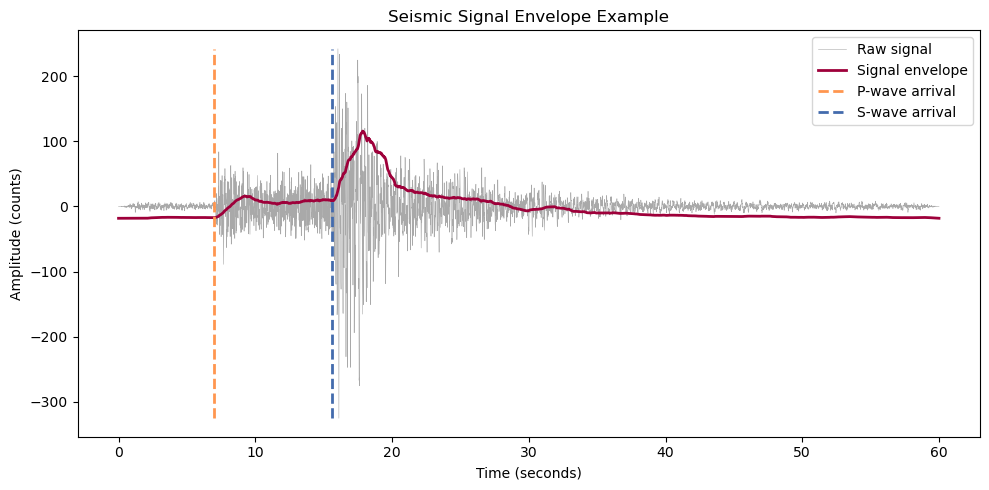

In [10]:
i = 57 # example trace
fig, ax = plt.subplots(1,1,figsize=(10,5))
sig = raw_signals[i][:,2]
ax.plot(np.linspace(0,60,6000), sig, color='darkgrey', linewidth=0.4, label='Raw signal')
ax.plot(np.linspace(0,60,6000), signal_envelopes[i], color='xkcd:cranberry', linewidth=2, label='Signal envelope')
p_wave = metadata.iloc[i]['p_arrival_sample']
s_wave = metadata.iloc[i]['s_arrival_sample']
ax.vlines(p_wave/100.0, sig.min(), sig.max(), color='xkcd:pastel orange', linewidth=2, linestyle='--', label='P-wave arrival')
ax.vlines(s_wave/100.0, sig.min(), sig.max(), color='xkcd:french blue', linewidth=2, linestyle='--', label='S-wave arrival')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Amplitude (counts)')
ax.set_title('Seismic Signal Envelope Example')
ax.legend()
plt.tight_layout()

### Create subsets of earthquake-only data (no noise samples)

In [11]:
earthquakes_indices = np.array(list(metadata[metadata['trace_category']=='earthquake_local'].index))
raw_signals_earthquakes_only = raw_signals[earthquakes_indices]
envelopes_earthquakes_only = signal_envelopes_resamp[earthquakes_indices]
metadata_earthquakes_only = metadata[metadata['trace_category']=='earthquake_local']

### Reshape signal envelopes so they have the correct format for input into the LSTM models

In [12]:
signal_envelopes_resamp = np.reshape(signal_envelopes_resamp, (signal_envelopes_resamp.shape[0], 1, signal_envelopes_resamp.shape[1]))
envelopes_earthquakes_only = np.reshape(envelopes_earthquakes_only, (envelopes_earthquakes_only.shape[0], 1, envelopes_earthquakes_only.shape[1]))

## Model training & evaluation

### 1. Classification LSTM model training & evaluation to predict whether signals are 'earthquake' or 'noise'

In [ ]:
# Set up model callbacks
epochs = 50
callbacks_c = architectures.callbacks_setup(model_tag='lstm_classification', epochs=epochs)

# Fit model
train_dataset_c, val_dataset_c, test_dataset_c = training_utils.prepare_datasets(imgs=signal_envelopes_resamp, labels=classifier_labels, batch_size=32)
input_shape = (signal_envelopes_resamp.shape[1], signal_envelopes_resamp.shape[2])
classifier_model = architectures.build_compile_classification_lstm(input_shape=input_shape, learning_rate=1e-5, loss='binary_crossentropy', metrics=['accuracy'])
classifier_history = classifier_model.fit(train_dataset_c, epochs=epochs, callbacks=callbacks_c, validation_data=val_dataset_c)

# Evaluate model and plot results
training_utils.evaluate_classification_model(classifier_model, train_dataset_c, test_dataset_c)
training_utils.plot_training_history(classifier_history)

Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7058 - loss: 0.6540 - val_accuracy: 0.8307 - val_loss: 0.4925 - learning_rate: 1.0000e-05
Epoch 2/50
 583/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8280 - loss: 0.4888

### 2. Regression LSTM model training & evaluation for earthquake magnitude prediction

In [ ]:
# Set up model callbacks
epochs = 50
callbacks_mag = architectures.callbacks_setup(model_tag='lstm_regression_magnitude', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['source_magnitude'])
train_dataset_mag, val_dataset_mag, test_dataset_mag = training_utils.prepare_datasets(imgs=envelopes_earthquakes_only, labels=labels, batch_size=32)
input_shape = (envelopes_earthquakes_only.shape[1], envelopes_earthquakes_only.shape[2])
model_magnitude = architectures.build_compile_regression_lstm(input_shape=input_shape, learning_rate=1e-4, loss='mse', metrics=['mae'])
model_magnitude_history = model_magnitude.fit(train_dataset_mag, epochs=epochs, callbacks=callbacks_mag, validation_data=val_dataset_mag)

# Evaluate model and plot results
training_utils.evaluate_regression_model(model_magnitude, train_dataset_mag, test_dataset_mag, 'Source Magnitude', scaler=None)
training_utils.plot_training_history(model_magnitude_history)

### 3. Regression LSTM model training & evaluation for earthquake p-wave arrival time prediction

In [ ]:
# Set up model callbacks
epochs = 50
callbacks_pwave = architectures.callbacks_setup(model_tag='lstm_regression_pwave', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['p_arrival_sample'])
train_dataset_pwave, val_dataset_pwave, test_dataset_pwave = training_utils.prepare_datasets(imgs=envelopes_earthquakes_only, labels=labels, batch_size=32)
input_shape = (envelopes_earthquakes_only.shape[1], envelopes_earthquakes_only.shape[2])
model_pwave = build_compile_regression_lstm(input_shape=input_shape, learning_rate=1e-4, loss='mse', metrics=['mae'])
model_pwave_history = model_pwave.fit(train_dataset_pwave, epochs=epochs, callbacks=callbacks_pwave, validation_data=val_dataset_pwave)

# Evaluate model and plot results
training_utils.evaluate_regression_model(model_pwave, train_dataset_pwave, test_dataset_pwave, 'P-Wave Arrival', scaler=None)
training_utils.plot_training_history(model_pwave_history)

### 4. Regression LSTM model training & evaluation for earthquake s-wave arrival time prediction

In [ ]:
# Set up model callbacks
epochs = 50
callbacks_swave = architectures.callbacks_setup(model_tag='lstm_regression_swave', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['s_arrival_sample'])
train_dataset_swave, val_dataset_swave, test_dataset_swave = training_utils.prepare_datasets(imgs=envelopes_earthquakes_only, labels=labels, batch_size=32)
input_shape = (envelopes_earthquakes_only.shape[1], envelopes_earthquakes_only.shape[2])
model_swave = build_compile_regression_lstm(input_shape=input_shape, learning_rate=1e-4, loss='mse', metrics=['mae'])
model_swave_history = model_swave.fit(train_dataset_swave, epochs=epochs, callbacks=callbacks_swave, validation_data=val_dataset_swave)

# Evaluate model and plot results
training_utils.evaluate_regression_model(model_swave, train_dataset_swave, test_dataset_swave, 'S-Wave Arrival', scaler=None)
training_utils.plot_training_history(model_swave_history)